Loaded 852 daily returns × 20 assets
Searching for optimal gamma...

=== Performance Summary ===
Average risk-free allocation : 74.08%
Optimal gamma                : 0.2911
Achieved annual volatility   : 25.02%
Annual return (price)        : 14.67%
Annual Sharpe ratio          : 0.44
Final portfolio value        : 1293862.46 €
Final cumulative return      : 29.39%
Average diversification      : 79.97%
Maximum drawdown             : 21.38%
Fee cost                     : 0.4447%


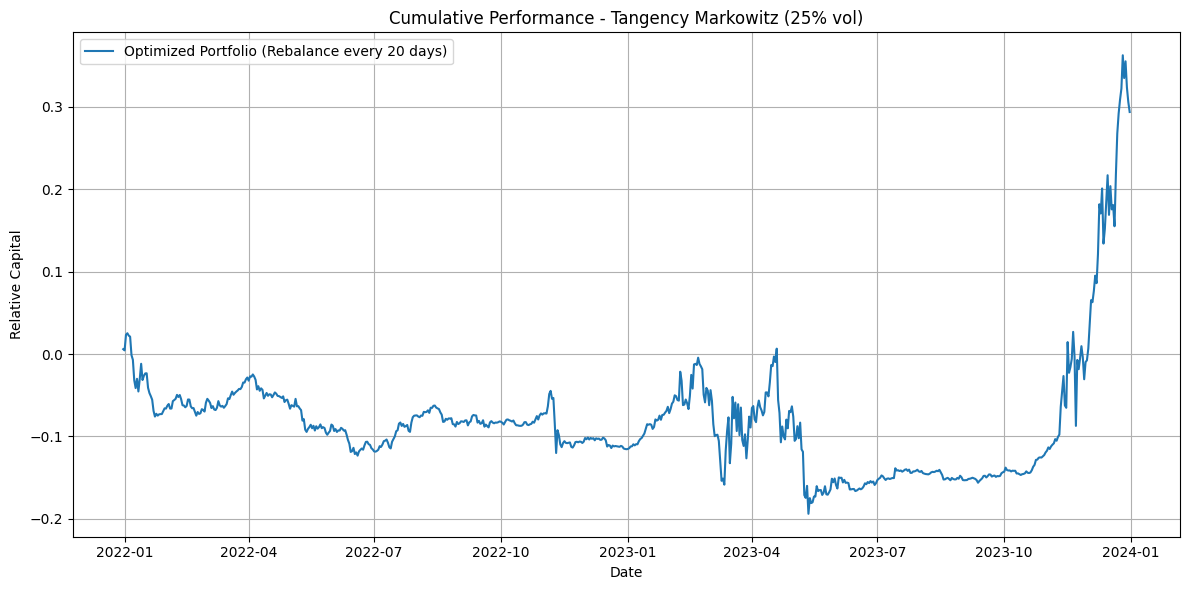

<Figure size 1400x600 with 0 Axes>

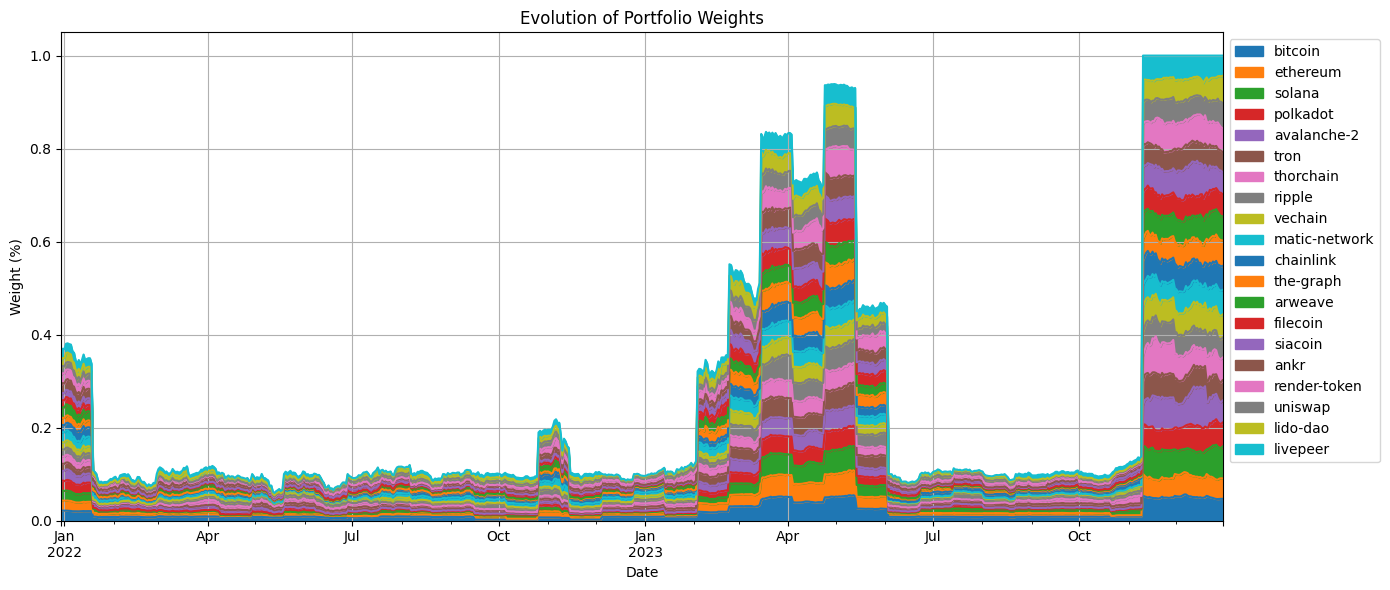

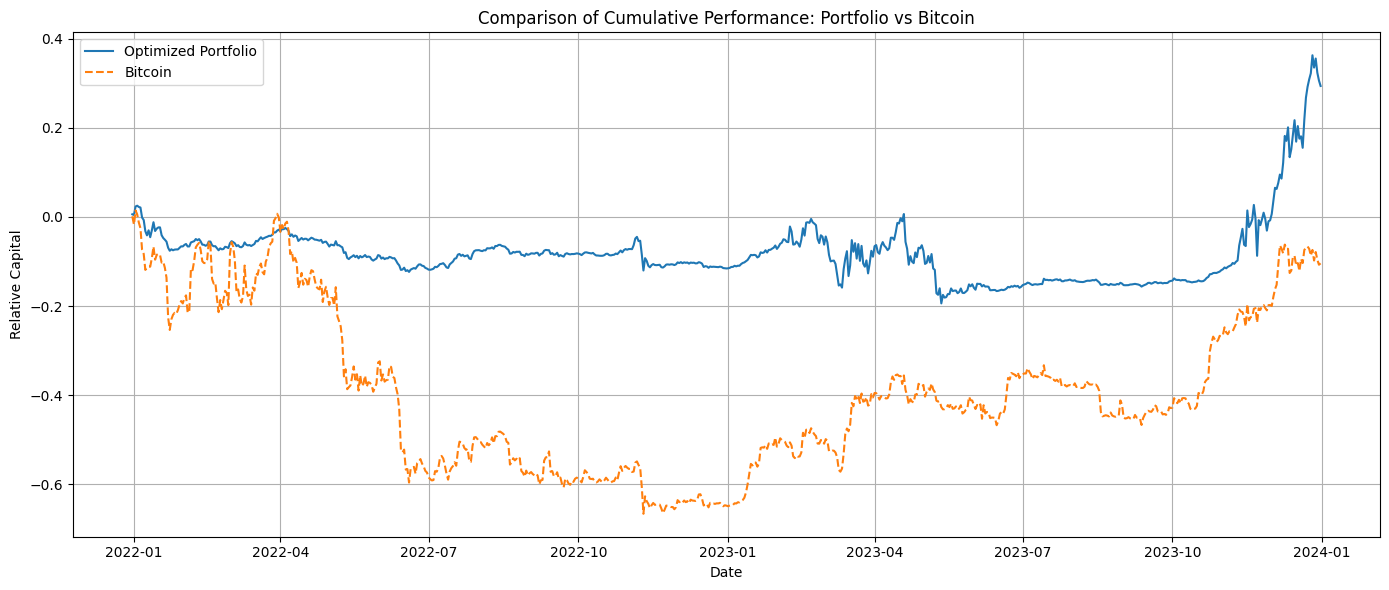

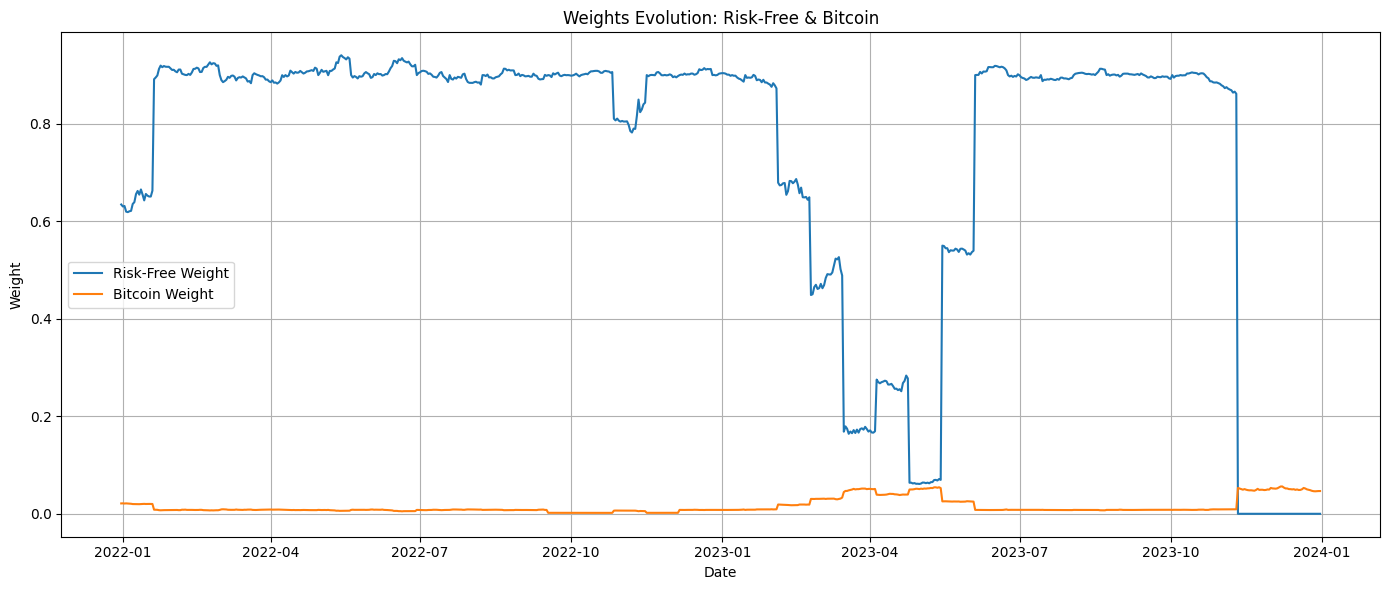

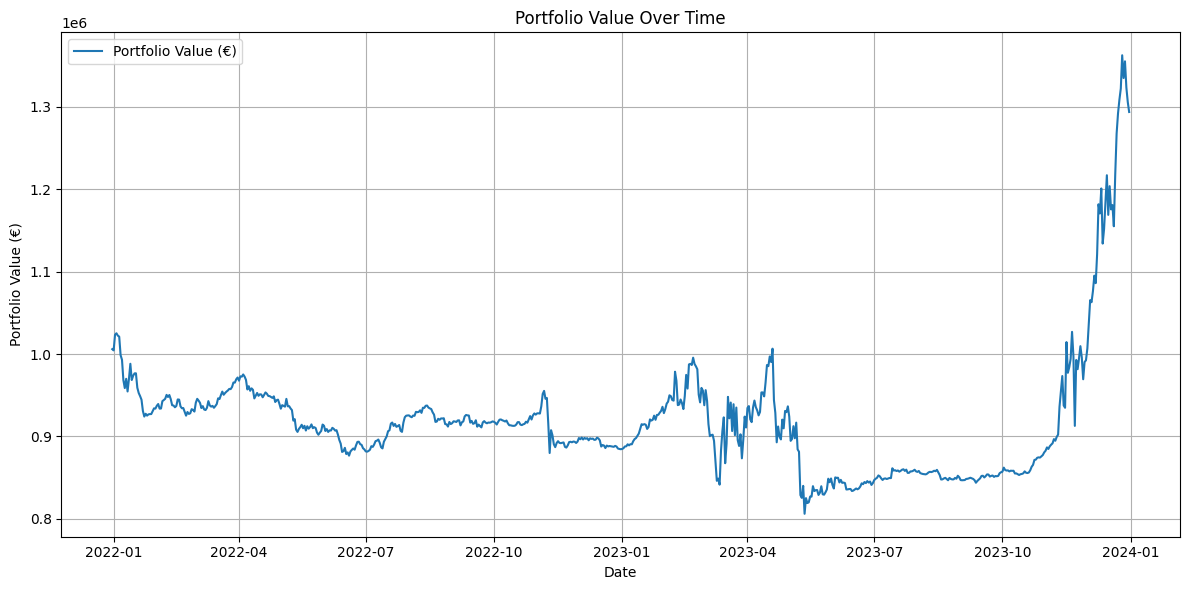

In [4]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

# 0) Load and prepare data
df = pd.read_csv(
    "data.csv",
    sep=";",                    # CSV uses semicolons
    parse_dates=["date"],       # parse date column
    index_col="date",           # use it as index
    date_format="%Y-%m-%d"      # enforce ISO date format
)

returns = df.pct_change().dropna()
returns = returns[(returns.index >= "2021-09-01") & (returns.index < "2024-01-01")]

print(f"Loaded {returns.shape[0]} daily returns × {returns.shape[1]} assets")

# Safety check
window = 120
if len(returns) <= window + 5:
    raise ValueError(f"Not enough data ({len(returns)} rows) for window={window}")

# 1) Parameters
vol_target_annual = 0.25
vol_target_daily = vol_target_annual / np.sqrt(365)
risk_free_rate_annual = 0.05
risk_free_rate_daily = risk_free_rate_annual / 365
transaction_fee = 0.001
initial_portfolio_value = 1_000_000
rebalance_freq = 20

n_assets = returns.shape[1]

# 2) Run strategy for fixed gamma
def run_strategy_for_gamma(gamma):
    weights_history = []
    weights_rf_history = []
    portfolio_returns = []
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    total_fees = 0.0

    current_w = np.ones(n_assets) / n_assets
    current_w_rf = 0.0

    for t in range(window, len(returns) - 1):
        rebalance_today = (t - window) % rebalance_freq == 0
        window_returns = returns.iloc[t - window:t]

        if rebalance_today:
            mu = window_returns.mean().values
            Sigma = window_returns.cov().values

            w = cp.Variable(n_assets)
            w_rf = cp.Variable(1)

            risk_term = 0.5 * cp.quad_form(w, Sigma)
            expected_return = mu.T @ w + risk_free_rate_daily * w_rf
            objective = cp.Minimize(risk_term - gamma * expected_return)

            constraints = [
                w >= 0,
                w_rf >= 0,
                cp.sum(w) + w_rf == 1,
                w <= cp.mean(w) + 3e-3,
                w >= cp.mean(w) - 3e-3,
                w_rf <= 0.9
            ]

            prob = cp.Problem(objective, constraints)
            try:
                prob.solve(solver=cp.SCS, verbose=False)
                new_w = w.value
                new_w_rf = w_rf.value[0]
            except:
                new_w = current_w
                new_w_rf = current_w_rf
        else:
            new_w = current_w
            new_w_rf = current_w_rf

        # Transaction costs
        turnover = np.sum(np.abs(new_w - current_w))
        transaction_cost = turnover * transaction_fee * portfolio_value if rebalance_today else 0.0
        total_fees += transaction_cost

        # Portfolio return
        next_return = returns.iloc[t + 1].values
        gross_return = new_w_rf * risk_free_rate_daily + np.dot(new_w, next_return)
        net_return = gross_return - transaction_cost / portfolio_value
        portfolio_value *= (1 + net_return)
        portfolio_values.append(portfolio_value)

        weights_history.append(new_w)
        weights_rf_history.append(new_w_rf)
        portfolio_returns.append(net_return)

        # Drift update
        asset_returns = next_return
        rf_return = risk_free_rate_daily
        asset_values = new_w * (1 + asset_returns)
        rf_value = new_w_rf * (1 + rf_return)
        total_value = np.sum(asset_values) + rf_value

        current_w = asset_values / total_value
        current_w_rf = rf_value / total_value

    return np.array(portfolio_returns), portfolio_value, np.array(weights_history), np.array(portfolio_values), total_fees, np.array(weights_rf_history)

# 3) Objective function for root_scalar
def objective_gamma(gamma):
    rets = run_strategy_for_gamma(gamma)[0]
    if len(rets) == 0:
        return np.inf
    vol_annual = np.std(rets) * np.sqrt(365)
    return vol_annual - vol_target_annual

# 4) Search for gamma achieving target volatility
print("Searching for optimal gamma...")
try:
    result = root_scalar(objective_gamma, method='brentq', bracket=[1e-4, 1e4], xtol=1e-4)
    gamma_opt = result.root
except Exception as e:
    raise RuntimeError(f"Gamma search failed: {e}")

# 5) Run final strategy with optimal gamma
final_returns, portfolio_value, weights_hist, portfolio_values, total_fees, weights_rf_history = run_strategy_for_gamma(gamma_opt)

# 6) Compute metrics
T = len(final_returns)
ret_mean = np.mean(final_returns) * 365
final_ret = (365 / T) * (portfolio_value - initial_portfolio_value) / initial_portfolio_value
final_cumulative = (1 + final_returns).cumprod() - 1
final_vol = np.std(final_returns, ddof=1) * np.sqrt(365)
r_bar = np.mean(final_returns) * 365
sharpe = (r_bar - risk_free_rate_annual) / final_vol

# Diversification score
diversification_scores = []
for w in weights_hist:
    n = len(w)
    H_x = np.sum(w ** 2) / (np.sum(w) ** 2)
    D_x = (1 / n) * (1 / H_x)
    diversification_scores.append(D_x)
avg_diversification = np.mean(diversification_scores)

# Max drawdown
portfolio_values = np.array(portfolio_values)
cum_max = np.maximum.accumulate(portfolio_values)
drawdowns = (cum_max - portfolio_values) / cum_max
max_drawdown = np.max(drawdowns)

# Fee impact
fee_cost = total_fees / initial_portfolio_value

# 7) Print summary
avg_risk_free_allocation = np.mean(weights_rf_history) * 100
print(f"\n=== Performance Summary ===")
print(f"Average risk-free allocation : {avg_risk_free_allocation:.2f}%")
print(f"Optimal gamma                : {gamma_opt:.4f}")
print(f"Achieved annual volatility   : {final_vol:.2%}")
print(f"Annual return (price)        : {final_ret:.2%}")
print(f"Annual Sharpe ratio          : {sharpe:.2f}")
print(f"Final portfolio value        : {portfolio_value:.2f} €")
print(f"Final cumulative return      : {final_cumulative[-1]:.2%}")
print(f"Average diversification      : {avg_diversification:.2%}")
print(f"Maximum drawdown             : {max_drawdown:.2%}")
print(f"Fee cost                     : {fee_cost:.4%}")

# 8) Cumulative performance plot
plt.figure(figsize=(12, 6))
dates = returns.index[window + 1 : len(returns)]
plt.plot(dates, final_cumulative, label=f"Optimized Portfolio (Rebalance every {rebalance_freq} days)")
plt.title("Cumulative Performance - Tangency Markowitz (25% vol)")
plt.xlabel("Date")
plt.ylabel("Relative Capital")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 9) Evolution of portfolio weights
plt.figure(figsize=(14, 6))
assets = returns.columns
dates_weights = returns.index[window : len(returns) - 1]
weights_df = pd.DataFrame(weights_hist, columns=assets, index=dates_weights)
weights_df = weights_df.clip(lower=0)
weights_df.plot(kind='area', stacked=True, figsize=(14, 6))
plt.title("Evolution of Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weight (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 10) Comparison vs Bitcoin
btc_returns = returns["bitcoin"]  # adjust if BTC column has another name
btc_cumulative = (1 + btc_returns).cumprod() - 1
btc_cumulative = btc_cumulative.loc[dates]

plt.figure(figsize=(14, 6))
plt.plot(dates, final_cumulative, label="Optimized Portfolio")
plt.plot(dates, btc_cumulative, label="Bitcoin", linestyle='--')
plt.title("Comparison of Cumulative Performance: Portfolio vs Bitcoin")
plt.xlabel("Date")
plt.ylabel("Relative Capital")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 11) Risk-free & Bitcoin weights over time
bitcoin_index = 0  # adjust index if BTC is not first
weights_bitcoin = weights_hist[:, bitcoin_index]
weights_rf = weights_rf_history

plt.figure(figsize=(14, 6))
plt.plot(dates, weights_rf, label="Risk-Free Weight")
plt.plot(dates, weights_bitcoin, label="Bitcoin Weight")
plt.title("Weights Evolution: Risk-Free & Bitcoin")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 12) Portfolio value (absolute)
plt.figure(figsize=(12, 6))
dates = returns.index[window + 1 : len(returns)]
plt.plot(dates, portfolio_values[1:], label="Portfolio Value (€)")
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
